To run the notebook on different machine, you need to adjust the following:
- Original preprocessed data directory
- Create 3 directories for ```nnUNet_raw```, ```nnUNet_preprocessed```, and ```nnUNet_results```
- Correct directory for nnunet raw in  ```create_nnunet_dataset_structure()``` function
- Correct directory in env variables
- Pick up the correct env variable export cell for your platform (Linux or Windows)

## Setup and Imports

In [1]:
! pip install numpy nibabel matplotlib pandas torch scipy tqdm plotly optuna SimpleITK

In [2]:
# must be done after installing pytorch
! pip install nnunetv2 


  Using cached argparse-1.4.0-py2.py3-none-any.whl.metadata (2.8 kB)
Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [3]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd
import torch
from scipy.ndimage import zoom
from tqdm import tqdm
import torch.nn.functional as F
from matplotlib.widgets import Slider
import plotly.graph_objects as go
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from torch.optim import Adam
from concurrent.futures import ThreadPoolExecutor, as_completed

from scipy.ndimage import rotate
import optuna

from optuna.pruners import MedianPruner
from torch.cuda.amp import autocast, GradScaler

import SimpleITK as sitk

import subprocess

from tqdm import tqdm

import shutil
import json

d:\Projects\tbi-lesion-segmentation\aims_venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Dataset Import

In [4]:
processed_data_dir = "E:\\AIMS_Data\\final_processed_data\\final_processed_data\\pytorch_individual"

images_dir = os.path.join(processed_data_dir, "images")
masks_dir = os.path.join(processed_data_dir, "masks")
metadata_dir = os.path.join(processed_data_dir, "metadata")

# print number of files in processed images and masks
print(f"Number of processed images: {len(os.listdir(images_dir))}")
print(f"Number of processed masks: {len(os.listdir(masks_dir))}")


Number of processed images: 548
Number of processed masks: 548


Loaded scan_0001:
Image tensor shape: torch.Size([1, 256, 256, 256])
Mask tensor shape: torch.Size([1, 256, 256, 256])
Has lesion: True
Lesion voxels: 2,150


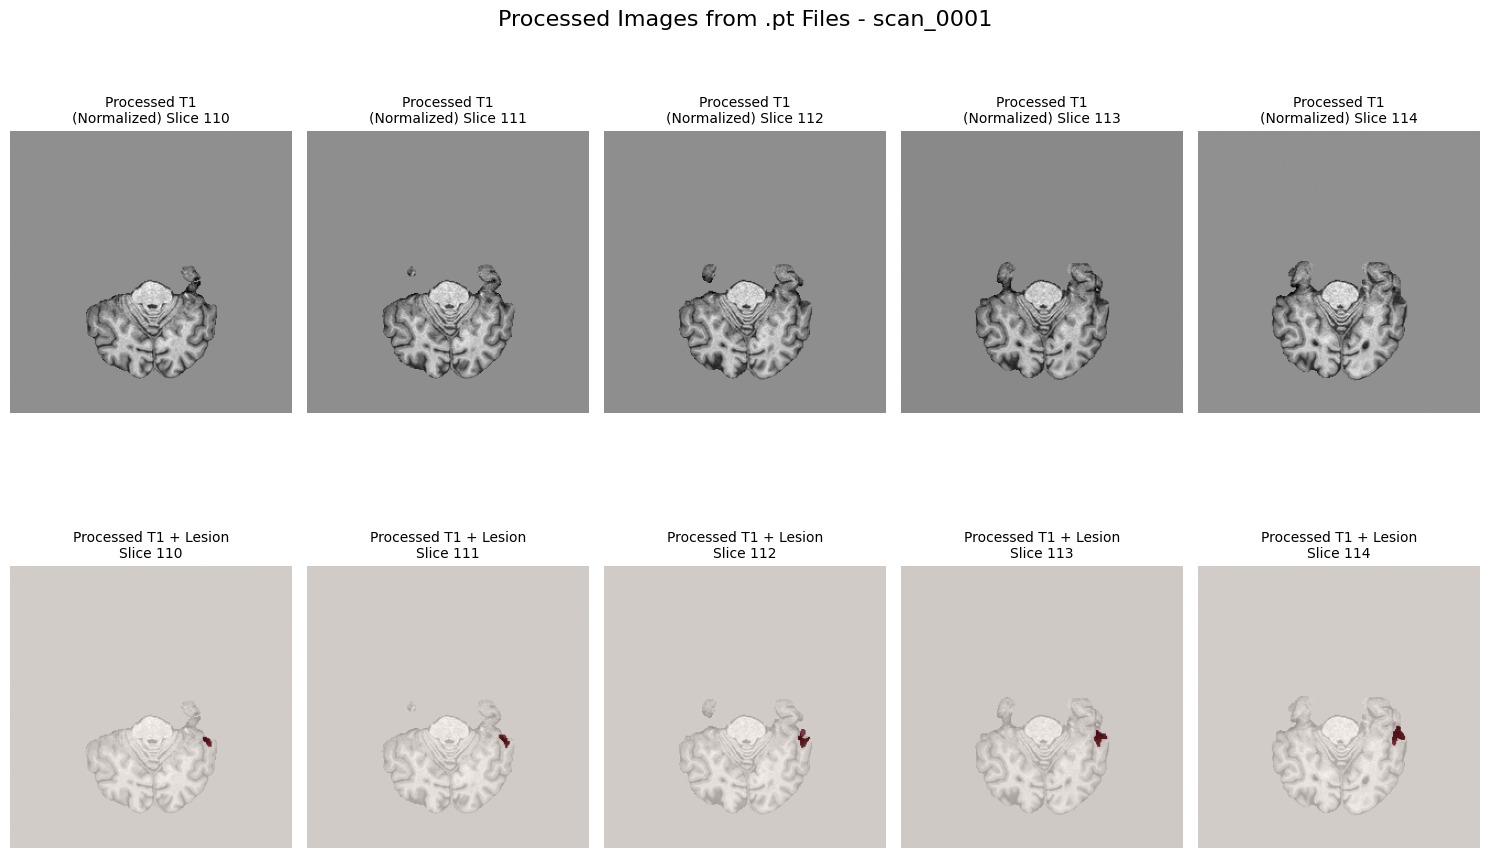


=== Statistics from .pt Files for scan_0001 ===
Processed T1 Image (from .pt file):
  Mean: 0.000000
  Std: 1.000000
  Min: -2.7810
  Max: 3.9446
  Shape: (256, 256, 256)

Lesion Mask (from .pt file):
  Lesion voxels: 2,150
  Total voxels: 16,777,216
  Lesion percentage: 0.0128%
  Shape: (256, 256, 256)

Metadata Statistics:
  Brain voxels: 1,310,865
  Brain mean: 0.000000
  Brain std: 1.000000
  Image range: [-2.7810, 3.9446]


In [5]:
# Define scan parameters
scan_id = 'scan_0001'
start_slice = 110
num_slices = 5

# Load the .pt files
image_path = os.path.join(images_dir, f"{scan_id}_image.pt")
mask_path = os.path.join(masks_dir, f"{scan_id}_mask.pt")
metadata_path = os.path.join(metadata_dir, f"{scan_id}_metadata.json")

# Load image tensor
image_data = torch.load(image_path, map_location='cpu')
image_tensor = image_data['image']  # Shape: [1, H, W, D]

# Load mask tensor
mask_data = torch.load(mask_path, map_location='cpu')
mask_tensor = mask_data['mask']  # Shape: [1, H, W, D]

# Load metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

# Remove channel dimension for visualization: [H, W, D]
image_array = image_tensor.squeeze(0).numpy()
mask_array = mask_tensor.squeeze(0).numpy()

print(f"Loaded {scan_id}:")
print(f"Image tensor shape: {image_tensor.shape}")
print(f"Mask tensor shape: {mask_tensor.shape}")
print(f"Has lesion: {metadata['statistics']['has_lesion']}")
print(f"Lesion voxels: {metadata['statistics']['lesion_voxels']:,}")

# Create visualization
fig, axes = plt.subplots(2, num_slices, figsize=(num_slices * 3, 10))

# Ensure axes is 2D even for single slice
if num_slices == 1:
    axes = axes.reshape(-1, 1)

for i in range(num_slices):
    slice_idx = start_slice + i
    
    # Check if slice index is valid
    if slice_idx >= image_array.shape[2]:
        print(f"⚠️ Slice {slice_idx} is out of bounds (max: {image_array.shape[2]-1}), skipping...")
        continue
    
    # Extract slices (transpose for proper orientation)
    image_slice = image_array[:, :, slice_idx].T
    mask_slice = mask_array[:, :, slice_idx].T
    
    # Row 1: Processed T1 image only
    axes[0, i].imshow(image_slice, cmap='gray', origin='lower')
    axes[0, i].set_title(f'Processed T1\n(Normalized) Slice {slice_idx}', fontsize=10)
    axes[0, i].axis('off')
    
    # Row 2: Processed T1 + Lesion overlay
    axes[1, i].imshow(image_slice, cmap='gray', origin='lower')
    if np.any(mask_slice > 0):  # Only overlay if there are lesions in this slice
        axes[1, i].imshow(mask_slice, cmap='Reds', alpha=0.6, origin='lower')
    axes[1, i].set_title(f'Processed T1 + Lesion\nSlice {slice_idx}', fontsize=10)
    axes[1, i].axis('off')

plt.tight_layout()
plt.suptitle(f'Processed Images from .pt Files - {scan_id}', fontsize=16, y=0.98)
plt.show()

# Print intensity statistics
print(f"\n=== Statistics from .pt Files for {scan_id} ===")

# Image stats (brain voxels only)
brain_mask = image_array != 0  # Background is 0 after normalization
brain_voxels = image_array[brain_mask]

print("Processed T1 Image (from .pt file):")
print(f"  Mean: {np.mean(brain_voxels):.6f}")
print(f"  Std: {np.std(brain_voxels):.6f}")
print(f"  Min: {np.min(brain_voxels):.4f}")
print(f"  Max: {np.max(brain_voxels):.4f}")
print(f"  Shape: {image_array.shape}")

# Lesion statistics
lesion_voxels = np.count_nonzero(mask_array)
total_voxels = mask_array.size
lesion_percentage = (lesion_voxels / total_voxels) * 100

print(f"\nLesion Mask (from .pt file):")
print(f"  Lesion voxels: {lesion_voxels:,}")
print(f"  Total voxels: {total_voxels:,}")
print(f"  Lesion percentage: {lesion_percentage:.4f}%")
print(f"  Shape: {mask_array.shape}")

# Metadata statistics
print(f"\nMetadata Statistics:")
print(f"  Brain voxels: {metadata['statistics']['brain_voxels']:,}")
print(f"  Brain mean: {metadata['statistics']['brain_mean']:.6f}")
print(f"  Brain std: {metadata['statistics']['brain_std']:.6f}")
print(f"  Image range: [{metadata['statistics']['image_range'][0]:.4f}, {metadata['statistics']['image_range'][1]:.4f}]")

## nnUNet setup

### Dataset conversion for nnUNet compatibility

Create nnU-Net Dataset Structure

In [6]:
def create_nnunet_dataset_structure():
    """Create nnU-Net compatible dataset structure"""
    
    # Set your nnUNet_raw path (adjust as needed)
    nnunet_raw = "E:/AIMS_Data/nnUNet_raw"  # or your path
    dataset_name = "Dataset600_TBILesion"  # Choose an unused ID
    
    dataset_path = os.path.join(nnunet_raw, dataset_name)
    
    # Create directories
    os.makedirs(os.path.join(dataset_path, "imagesTr"), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, "labelsTr"), exist_ok=True)
    os.makedirs(os.path.join(dataset_path, "imagesTs"), exist_ok=True)  # Optional for test data
    
    return dataset_path

In [7]:
# dataset_path = create_nnunet_dataset_structure()
# print(f"Created dataset structure at: {dataset_path}")

Convert Your .pt Files to nnU-Net Format

In [8]:
def convert_pt_to_nnunet_format(processed_data_dir, dataset_path, train_ratio=0.85):
    """Enhanced conversion that preserves more metadata"""
    
    images_dir = os.path.join(processed_data_dir, "images")
    masks_dir = os.path.join(processed_data_dir, "masks")
    metadata_dir = os.path.join(processed_data_dir, "metadata")
    
    # Get all scan IDs
    image_files = [f for f in os.listdir(images_dir) if f.endswith('_image.pt')]
    scan_ids = [f.replace('_image.pt', '') for f in image_files]
    
    print(f"Found {len(scan_ids)} scans to convert")
    
    # Split into train/test
    n_train = int(len(scan_ids) * train_ratio)
    train_ids = scan_ids[:n_train]
    test_ids = scan_ids[n_train:]
    
    print(f"Training scans: {len(train_ids)}")
    print(f"Test scans: {len(test_ids)}")
    
    converted_count = 0
    metadata_preserved = []
    
    for split, ids in [("Tr", train_ids), ("Ts", test_ids)]:
        for scan_id in ids:
            try:
                # Load image tensor
                image_path = os.path.join(images_dir, f"{scan_id}_image.pt")
                mask_path = os.path.join(masks_dir, f"{scan_id}_mask.pt")
                metadata_path = os.path.join(metadata_dir, f"{scan_id}_metadata.json")
                
                image_data = torch.load(image_path, map_location='cpu')
                mask_data = torch.load(mask_path, map_location='cpu')
                
                # Load metadata
                with open(metadata_path, 'r') as f:
                    metadata = json.load(f)
                
                # Extract arrays and remove channel dimension
                image_array = image_data['image'].squeeze(0).numpy().astype(np.float32)  # Preserve precision
                mask_array = mask_data['mask'].squeeze(0).numpy().astype(np.uint8)
                
                # Create enhanced affine matrix with spacing if available
                if 'spacing' in metadata:
                    spacing = metadata['spacing']
                    affine = np.diag([spacing[0], spacing[1], spacing[2], 1.0])
                else:
                    affine = np.eye(4)
                
                # Create NIfTI with enhanced header
                image_nii = nib.Nifti1Image(image_array, affine)
                mask_nii = nib.Nifti1Image(mask_array, affine)
                
                # Preserve some metadata in NIfTI header
                if 'statistics' in metadata:
                    stats = metadata['statistics']
                    # Store key stats in NIfTI header description (limited space)
                    description = f"Lesion:{stats.get('has_lesion', False)},LesionVox:{stats.get('lesion_voxels', 0)}"
                    image_nii.header['descrip'] = description.encode()[:79]  # Max 80 chars
                
                # Save in nnU-Net format
                image_filename = f"{scan_id}_0000.nii.gz"
                mask_filename = f"{scan_id}.nii.gz"
                
                image_save_path = os.path.join(dataset_path, f"images{split}", image_filename)
                mask_save_path = os.path.join(dataset_path, f"labels{split}", mask_filename)
                
                nib.save(image_nii, image_save_path)
                if split == "Tr":
                    nib.save(mask_nii, mask_save_path)
                
                # Preserve full metadata separately
                metadata_preserved.append({
                    'scan_id': scan_id,
                    'split': split,
                    'original_metadata': metadata,
                    'file_paths': {
                        'image': image_save_path,
                        'mask': mask_save_path if split == "Tr" else None
                    }
                })
                
                converted_count += 1
                
                if converted_count % 50 == 0:
                    print(f"Converted {converted_count} scans...")
                    
            except Exception as e:
                print(f"Error converting {scan_id}: {e}")
                continue
    
    # Save preserved metadata
    metadata_file = os.path.join(dataset_path, "preserved_metadata.json")
    with open(metadata_file, 'w') as f:
        json.dump(metadata_preserved, f, indent=2)
    
    print(f"Successfully converted {converted_count} scans")
    print(f"Preserved metadata saved to: {metadata_file}")
    return len(train_ids), len(test_ids)

In [9]:
# # Convert your data
# n_train, n_test = convert_pt_to_nnunet_format(processed_data_dir, dataset_path)

Create dataset.json File

In [10]:
def create_dataset_json(dataset_path, num_training):
    """Create dataset.json file for nnU-Net"""
    
    dataset_json = {
        "channel_names": {
            "0": "T1"  # Your T1-weighted MRI scans
        },
        "labels": {
            "background": 0,
            "lesion": 1
        },
        "numTraining": num_training,
        "file_ending": ".nii.gz",
        "dataset_name": "TBI_Lesion_Segmentation",
        "reference": "AIMS TBI Challenge",
        "licence": "Your License",
        "description": "Traumatic Brain Injury Lesion Segmentation Dataset"
    }
    
    # Save dataset.json
    json_path = os.path.join(dataset_path, "dataset.json")
    with open(json_path, 'w') as f:
        json.dump(dataset_json, f, indent=2)
    
    print(f"Created dataset.json with {num_training} training cases")
    print(f"Saved to: {json_path}")

In [11]:
# create_dataset_json(dataset_path, n_train)

Verify Dataset Structure

In [12]:
def verify_dataset_structure(dataset_path):
    """Verify the dataset structure is correct"""
    
    print("Verifying dataset structure...")
    
    # Check folder structure
    required_folders = ["imagesTr", "labelsTr"]
    for folder in required_folders:
        folder_path = os.path.join(dataset_path, folder)
        if not os.path.exists(folder_path):
            print(f"❌ Missing folder: {folder}")
            return False
        else:
            print(f"✅ Found folder: {folder}")
    
    # Check dataset.json
    json_path = os.path.join(dataset_path, "dataset.json")
    if not os.path.exists(json_path):
        print("❌ Missing dataset.json")
        return False
    else:
        print("✅ Found dataset.json")
    
    # Check file counts
    images_tr = len([f for f in os.listdir(os.path.join(dataset_path, "imagesTr")) if f.endswith('.nii.gz')])
    labels_tr = len([f for f in os.listdir(os.path.join(dataset_path, "labelsTr")) if f.endswith('.nii.gz')])
    
    print(f"Training images: {images_tr}")
    print(f"Training labels: {labels_tr}")
    
    if images_tr != labels_tr:
        print("❌ Mismatch between number of images and labels")
        return False
    
    # Check file naming convention
    sample_files = os.listdir(os.path.join(dataset_path, "imagesTr"))[:5]
    for file in sample_files:
        if not file.endswith('_0000.nii.gz'):
            print(f"❌ Incorrect naming: {file} (should end with _0000.nii.gz)")
            return False
    
    print("✅ Dataset structure verification passed!")
    return True



In [13]:
# verify_dataset_structure(dataset_path)

Complete Dataset Conversion

In [14]:
# Complete conversion script
def convert_tbi_dataset_to_nnunet():
    """Complete conversion from your .pt format to nnU-Net format"""
    
    
    # Step 1: Create dataset structure
    dataset_path = create_nnunet_dataset_structure()
    
    # Step 2: Convert data
    n_train, n_test = convert_pt_to_nnunet_format(processed_data_dir, dataset_path)
    
    # Step 3: Create dataset.json
    create_dataset_json(dataset_path, n_train)
    
    # Step 4: Verify structure
    if verify_dataset_structure(dataset_path):
        print("\n🎉 Dataset successfully converted to nnU-Net format!")
        print(f"Dataset location: {dataset_path}")
        print("\nNext steps:")
        print("1. Set your environment variables")
        print("2. Run: nnUNetv2_plan_and_preprocess -d 600 --verify_dataset_integrity")
        print("3. Run: nnUNetv2_train 600 3d_fullres 0 --npz")
    else:
        print("❌ Dataset conversion failed!")

# Run the conversion


In [15]:
convert_tbi_dataset_to_nnunet()

Found 548 scans to convert
Training scans: 465
Test scans: 83
Converted 50 scans...
Converted 100 scans...
Converted 150 scans...
Converted 200 scans...
Converted 250 scans...
Converted 300 scans...
Converted 350 scans...
Converted 400 scans...
Converted 450 scans...
Converted 500 scans...
Successfully converted 548 scans
Preserved metadata saved to: E:/AIMS_Data/nnUNet_raw\Dataset600_TBILesion\preserved_metadata.json
Created dataset.json with 465 training cases
Saved to: E:/AIMS_Data/nnUNet_raw\Dataset600_TBILesion\dataset.json
Verifying dataset structure...
✅ Found folder: imagesTr
✅ Found folder: labelsTr
✅ Found dataset.json
Training images: 465
Training labels: 465
✅ Dataset structure verification passed!

🎉 Dataset successfully converted to nnU-Net format!
Dataset location: E:/AIMS_Data/nnUNet_raw\Dataset600_TBILesion

Next steps:
1. Set your environment variables
2. Run: nnUNetv2_plan_and_preprocess -d 600 --verify_dataset_integrity
3. Run: nnUNetv2_train 600 3d_fullres 0 --npz


### env variable setup

For Linux

In [16]:
# ! export nnUNet_raw="/media/fabian/nnUNet_raw"
# ! export nnUNet_preprocessed="/media/fabian/nnUNet_preprocessed"
# ! export nnUNet_results="/media/fabian/nnUNet_results"
# ! export nnUNet_n_proc_DA=12

For windows (PowerShell)

In [18]:
os.environ['nnUNet_raw'] = "E:/AIMS_Data/nnUNet_raw"
os.environ['nnUNet_preprocessed'] = "E:/AIMS_Data/nnUNet_preprocessed"
os.environ['nnUNet_results'] = "E:/AIMS_Data/nnUNet_results"
os.environ['nnUNet_n_proc_DA'] = "12"

In [19]:
# Verify the environment variables are set
print("Environment variables set:")
print(f"nnUNet_raw: {os.environ.get('nnUNet_raw')}")
print(f"nnUNet_preprocessed: {os.environ.get('nnUNet_preprocessed')}")
print(f"nnUNet_results: {os.environ.get('nnUNet_results')}")
print(f"nnUNet_n_proc_DA: {os.environ.get('nnUNet_n_proc_DA')}")

Environment variables set:
nnUNet_raw: E:/AIMS_Data/nnUNet_raw
nnUNet_preprocessed: E:/AIMS_Data/nnUNet_preprocessed
nnUNet_results: E:/AIMS_Data/nnUNet_results
nnUNet_n_proc_DA: 12
